# 数据集信息

### 内容


“预测行为以留住客户。您可以分析所有相关的客户数据并制定有针对性的客户保留计划。”[IBM 样本数据集]

每行代表一个客户，每列包含在列元数据中描述的客户属性。
该数据集包括以下信息：


- 上个月内离开的客户 – 该列称为 Churn
- 每个客户已注册的服务——电话、多条线路、互联网、在线安全、在线备份、设备保护、技术支持以及流媒体电视和电影
- 客户帐户信息——他们成为客户的时间、合同、付款方式、无纸化账单、每月费用和总费用
- 有关客户的人口统计信息——性别、年龄范围，以及他们是否有伴侣和家属

# <a id="2">导入包和数据集+数据处理</a> 

In [2]:
import pandas as pd 
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
# 用于matplotlib正常显示
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
type(df)

pandas.core.frame.DataFrame

In [4]:
df.info() # 查看每一个数据项的数据类型（dtype）

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# 将TotalCharges（总花费）列类型转换为数字类型
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 
df['TotalCharges'].dtype

dtype('float64')

将列从字符串更改为数字后，可能无法识别某些值，从而导致缺失值。
因此需要检查一下

In [6]:
# 计算TotalCharges的缺失值
df['TotalCharges'].isnull().sum()

11

现在有11个缺失值，但它们可能表明在获取数据之前该客户没有收费。 

- “tenure”(任期)列表明某人成为客户的时间。
所以检查一下该特征上值为“0”的样本数量，如果依然能找到 11 个客户，就比较他们的索引是否与“缺失”值的索引匹配。

In [7]:
print(df[df['tenure'].isin([0])].index)
print(df[df['TotalCharges'].isna()].index)

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')
Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')


可见，总消费为0的确实都是任期为零的客户，打印第488行看一下

In [8]:
df.iloc[[488]]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No


TotalCharges为NaN，我们需要把它改为0

In [9]:
df.loc[:,'TotalCharges'] = df.loc[:,'TotalCharges'].replace(np.nan,0)
# 再次检查有无缺失值
df['TotalCharges'].isnull().sum()

0

为了方便，把SeniorCitizen(老年人)列的值类型由int64设置为字符串，因为年龄不适合求平均

In [10]:
df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [11]:
df['SeniorCitizen'].replace(0, 'No', inplace=True)
df['SeniorCitizen'].replace(1, 'Yes', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df['SeniorCitizen']

0        No
1        No
2        No
3        No
4        No
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: SeniorCitizen, Length: 7043, dtype: object

In [13]:
# count：数量统计，此列共有多少有效值
# mean：均值
# std：标准差
# min：最小值
# 25%：四分之一分位数
# 50%：二分之一分位数
# 75%：四分之三分位数
# max：最大值
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


In [14]:
for col in df.select_dtypes('object').columns: # 遍历dtype为object的列
    print(col, '- # unique values:', df[col].nunique()) # 打印列名 - 唯一值的个数 例如ID不重复，故结果为7043

customerID - # unique values: 7043
gender - # unique values: 2
SeniorCitizen - # unique values: 2
Partner - # unique values: 2
Dependents - # unique values: 2
PhoneService - # unique values: 2
MultipleLines - # unique values: 3
InternetService - # unique values: 3
OnlineSecurity - # unique values: 3
OnlineBackup - # unique values: 3
DeviceProtection - # unique values: 3
TechSupport - # unique values: 3
StreamingTV - # unique values: 3
StreamingMovies - # unique values: 3
Contract - # unique values: 3
PaperlessBilling - # unique values: 2
PaymentMethod - # unique values: 4
Churn - # unique values: 2


In [15]:
# for col in df.select_dtypes('object').columns:
#     print(col, '\n')
#     # value_counts()是一种查看表格某列中有多少个不同值的快捷方法，并计算每个不同值有在该列中有多少重复值。
#     print(df[col].value_counts(), '\n') 
col = df["gender"].value_counts()
col.values

array([3555, 3488], dtype=int64)

# <a id="3">探索性数据分析</a> 

我们将通过查看目标变量 (Churn) 的分布来启动我们的 EDA。
预计数据集不平衡，不到50%的客户离开公司

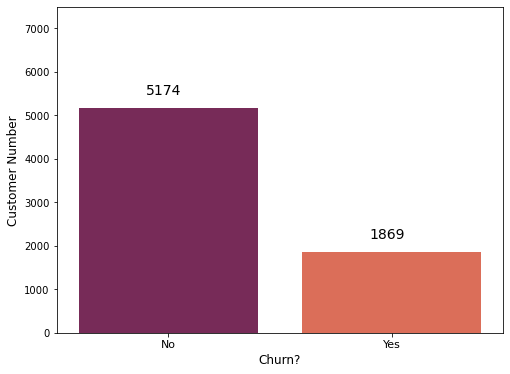

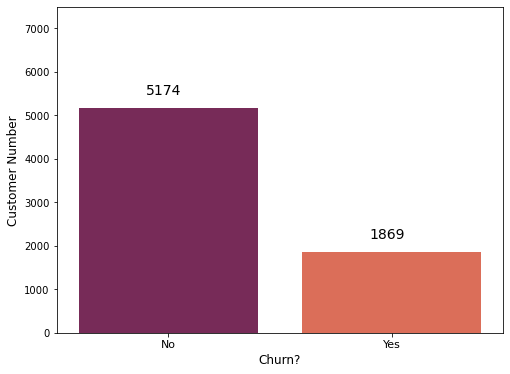

In [16]:
f = plt.figure(figsize=(8, 6))

ax = sns.countplot(x="Churn", data=df, palette="rocket")

plt.xlabel("Churn?", fontsize= 12) # X轴标签
plt.ylabel("Customer Number", fontsize= 12) # Y轴标签
plt.ylim(0,7500) # Y轴限制
plt.xticks([0,1],['No', 'Yes'], fontsize = 11) #X轴标签，字体大小

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 14) # 柱状图上方添加标签
    
f

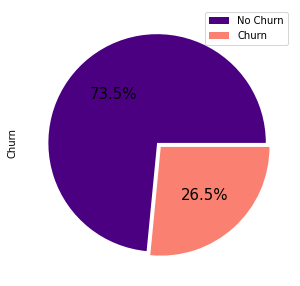

In [17]:
# 绘制饼图
plt.figure(figsize=(7,5))

df['Churn'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['indigo','salmon'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['No Churn', 'Churn'])
plt.show()

在此数据集中表示的时期，有 26.5% 的客户流失。

当我们继续分析功能时，我们可以将这个数字与每个类别中发现的流失百分比进行比较，让我们更好地了解给定功能对公司留住客户能力的影响。

In [18]:
# 标签编码 Churn 以使用 sns.barplot
le = LabelEncoder() # 将离散型的数据转换成 0 到 n − 1之间的数
df['Churn'] = le.fit_transform(df['Churn'])
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

我们可以将特征分为以下几组：
- 人口特征统计信息
- 服务相关的信息
- 帐户相关信息

对于每个组，我们将首先查看特征的分布。
然后，我们将检查每个类别的流失百分比，以了解它们与目标的关系。

In [19]:
demo_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents'] # Demographic人口统计学的

serv_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup'
                , 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'] # 服务相关数据项

cat_accinfo_features = ['Contract', 'PaperlessBilling', 'PaymentMethod'] # 账户数据项 - 非数字

num_accinfo_features = ['tenure', 'MonthlyCharges', 'TotalCharges'] # 账户数据项 - 数字

## <a id="31">客户特征</a> 

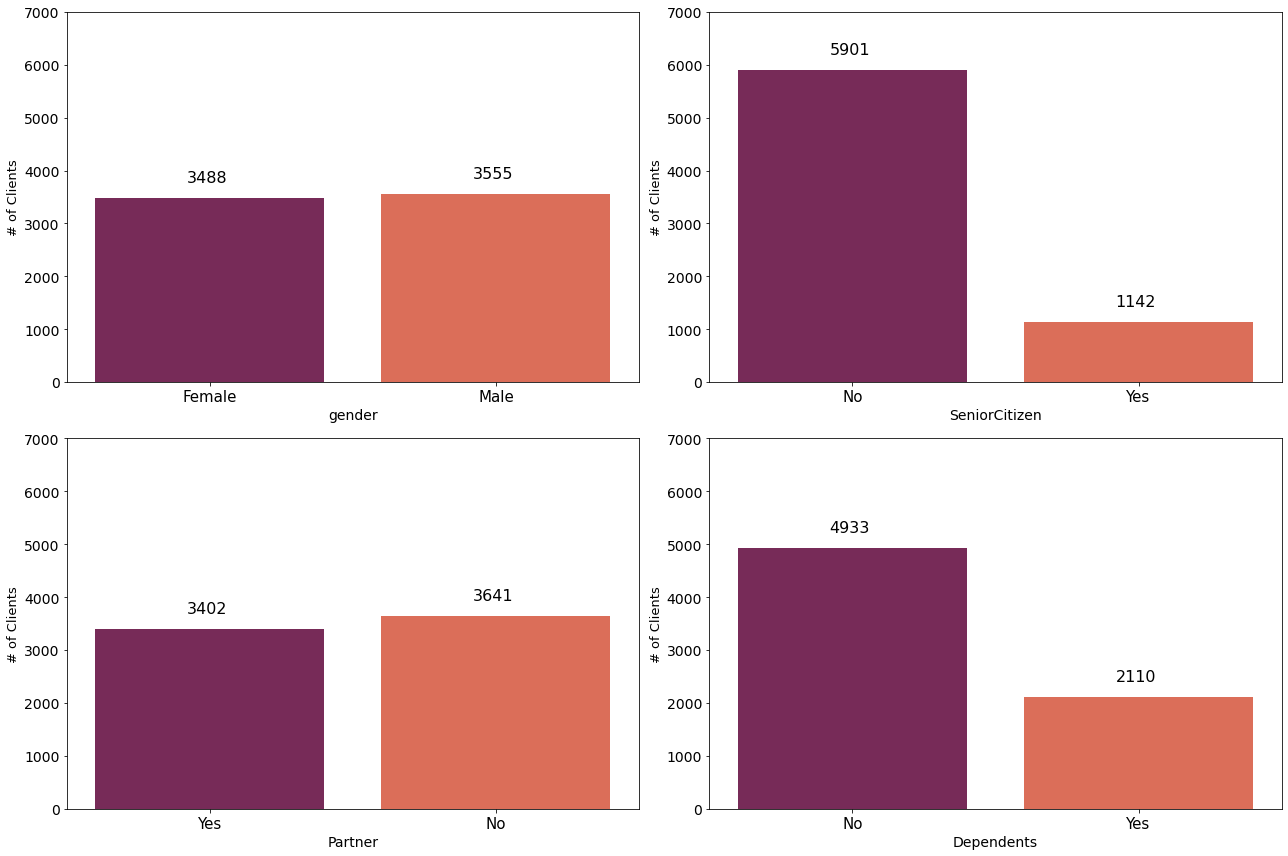

In [20]:
plt.figure(figsize=(18,12))

for i,col in enumerate(demo_features):   # 遍历取出demo_features中的下标，元素
    plt.subplot(2,2,i + 1) # 绘制 2 * 2 的子表
    
    ax = sns.countplot(data = df, x = col, palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7000)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 14)
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+300), fontsize= 16)
        
plt.tight_layout() # 自动调整函数

plt.show()

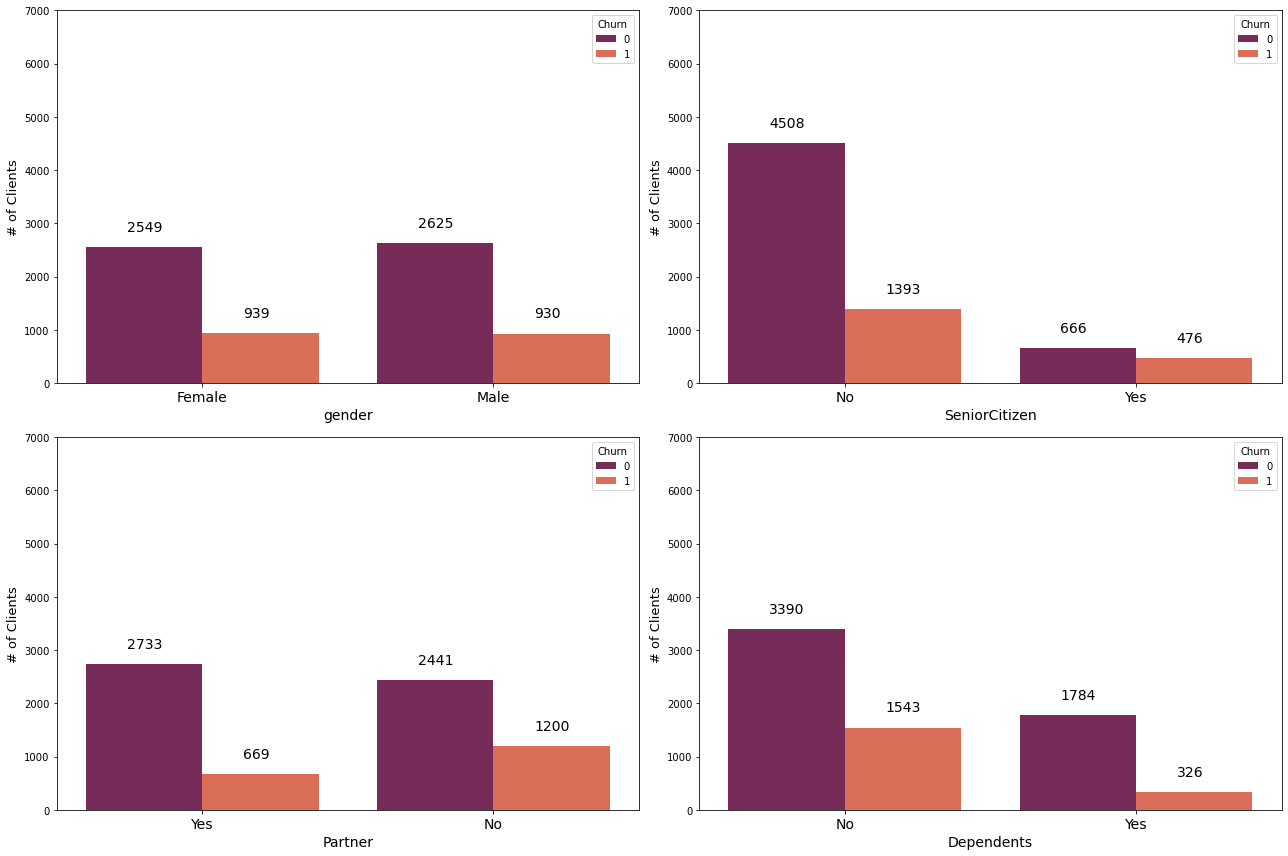

In [21]:
# 各分量之间不同值的去留图

plt.figure(figsize=(18,12))

for i,col in enumerate(demo_features):    
    plt.subplot(2,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn", palette = 'rocket') # 引入Churn特征分析

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7000)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.14, p.get_height()+300), fontsize= 14)

plt.tight_layout()

plt.show()

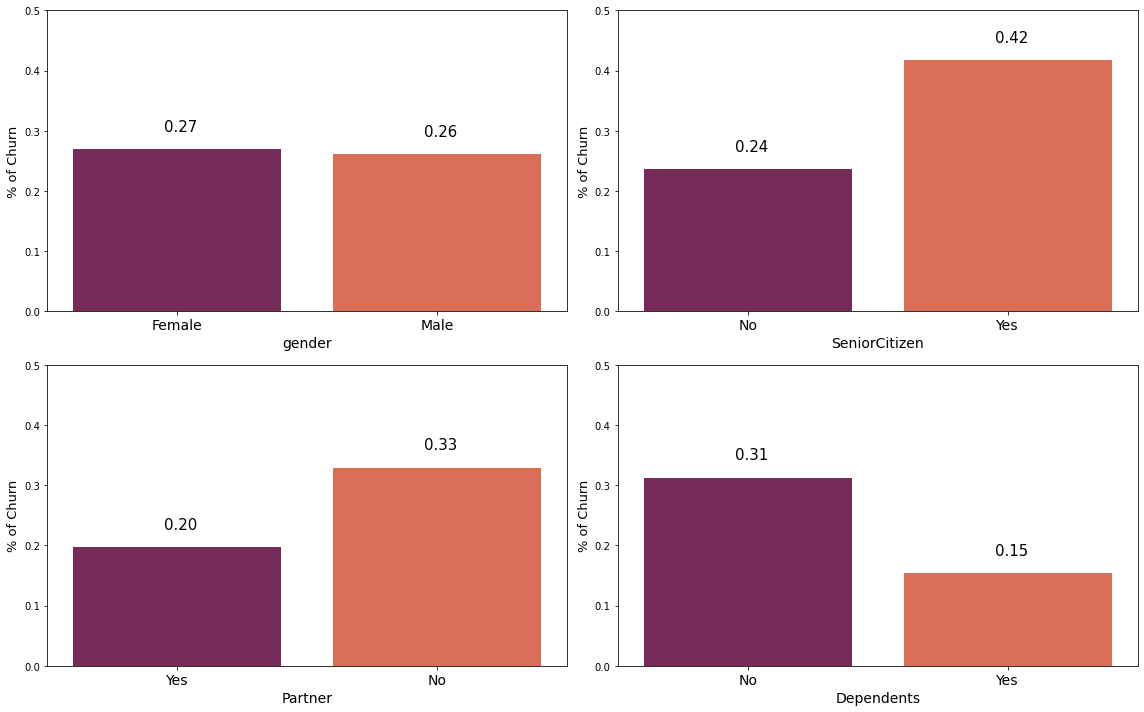

In [22]:
# 留 - 73.5% 去 - 26.5%
# 引入新的条件后的条件概率
plt.figure(figsize=(16,10))
for i,col in enumerate(demo_features):    
    plt.subplot(2,2,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df, palette = 'rocket', ci = None) # ci 置信区间

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("% of Churn", fontsize= 13)
    plt.ylim(0,0.5)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.35, p.get_height()+0.03),fontsize=15)

plt.tight_layout()

plt.show()

我们可以观察到每个特征：
- gender性别：男性和女性的流失率几乎没有任何差异；
- SeniorCitizen老年人: 资深客户的流失率在40%以上，表明该群体流失的可能性很大；
- Partner合作伙伴: 单一客户比有合作伙伴的客户更容易流失；
- Dependents家属: 与没有任何家属的客户相比，有家属的客户流失的可能性更小。

但有伙伴和有家属可能存在较大的耦合性，需要继续分析

In [23]:
# 按partner分为两组，显示每组的Dependents属性
df.groupby(['Partner'])['Dependents'].value_counts()

Partner  Dependents
No       No            3280
         Yes            361
Yes      Yes           1749
         No            1653
Name: Dependents, dtype: int64

In [24]:
# 算后验概率
df.groupby(by=['Partner', 'Dependents'])['Churn'].value_counts(normalize = True)

Partner  Dependents  Churn
No       No          0        0.657622
                     1        0.342378
         Yes         0        0.786704
                     1        0.213296
Yes      No          0        0.745917
                     1        0.254083
         Yes         0        0.857633
                     1        0.142367
Name: Churn, dtype: float64

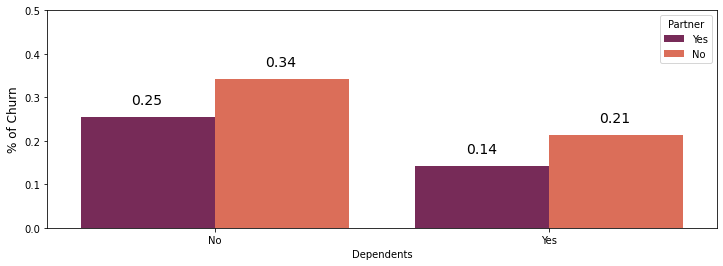

In [25]:
# 作图 纵坐标流失率
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "Dependents", y = "Churn", hue = "Partner", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.15, p.get_height()+0.03),fontsize=14)

plt.show()

我们可以看到，这两个特征都会导致流失的可能性。
有伴侣和合作伙伴的群体以及没有这两者的群体在流失可能性方面处于极端状态（分别为 14% 和 34%）。
有合作伙伴和没有家属的客户流失率接近我们数据集中流失的总体百分比25%，而“相反”组的客户流失率仍然较低。

## <a id="32">服务相关数据</a> 

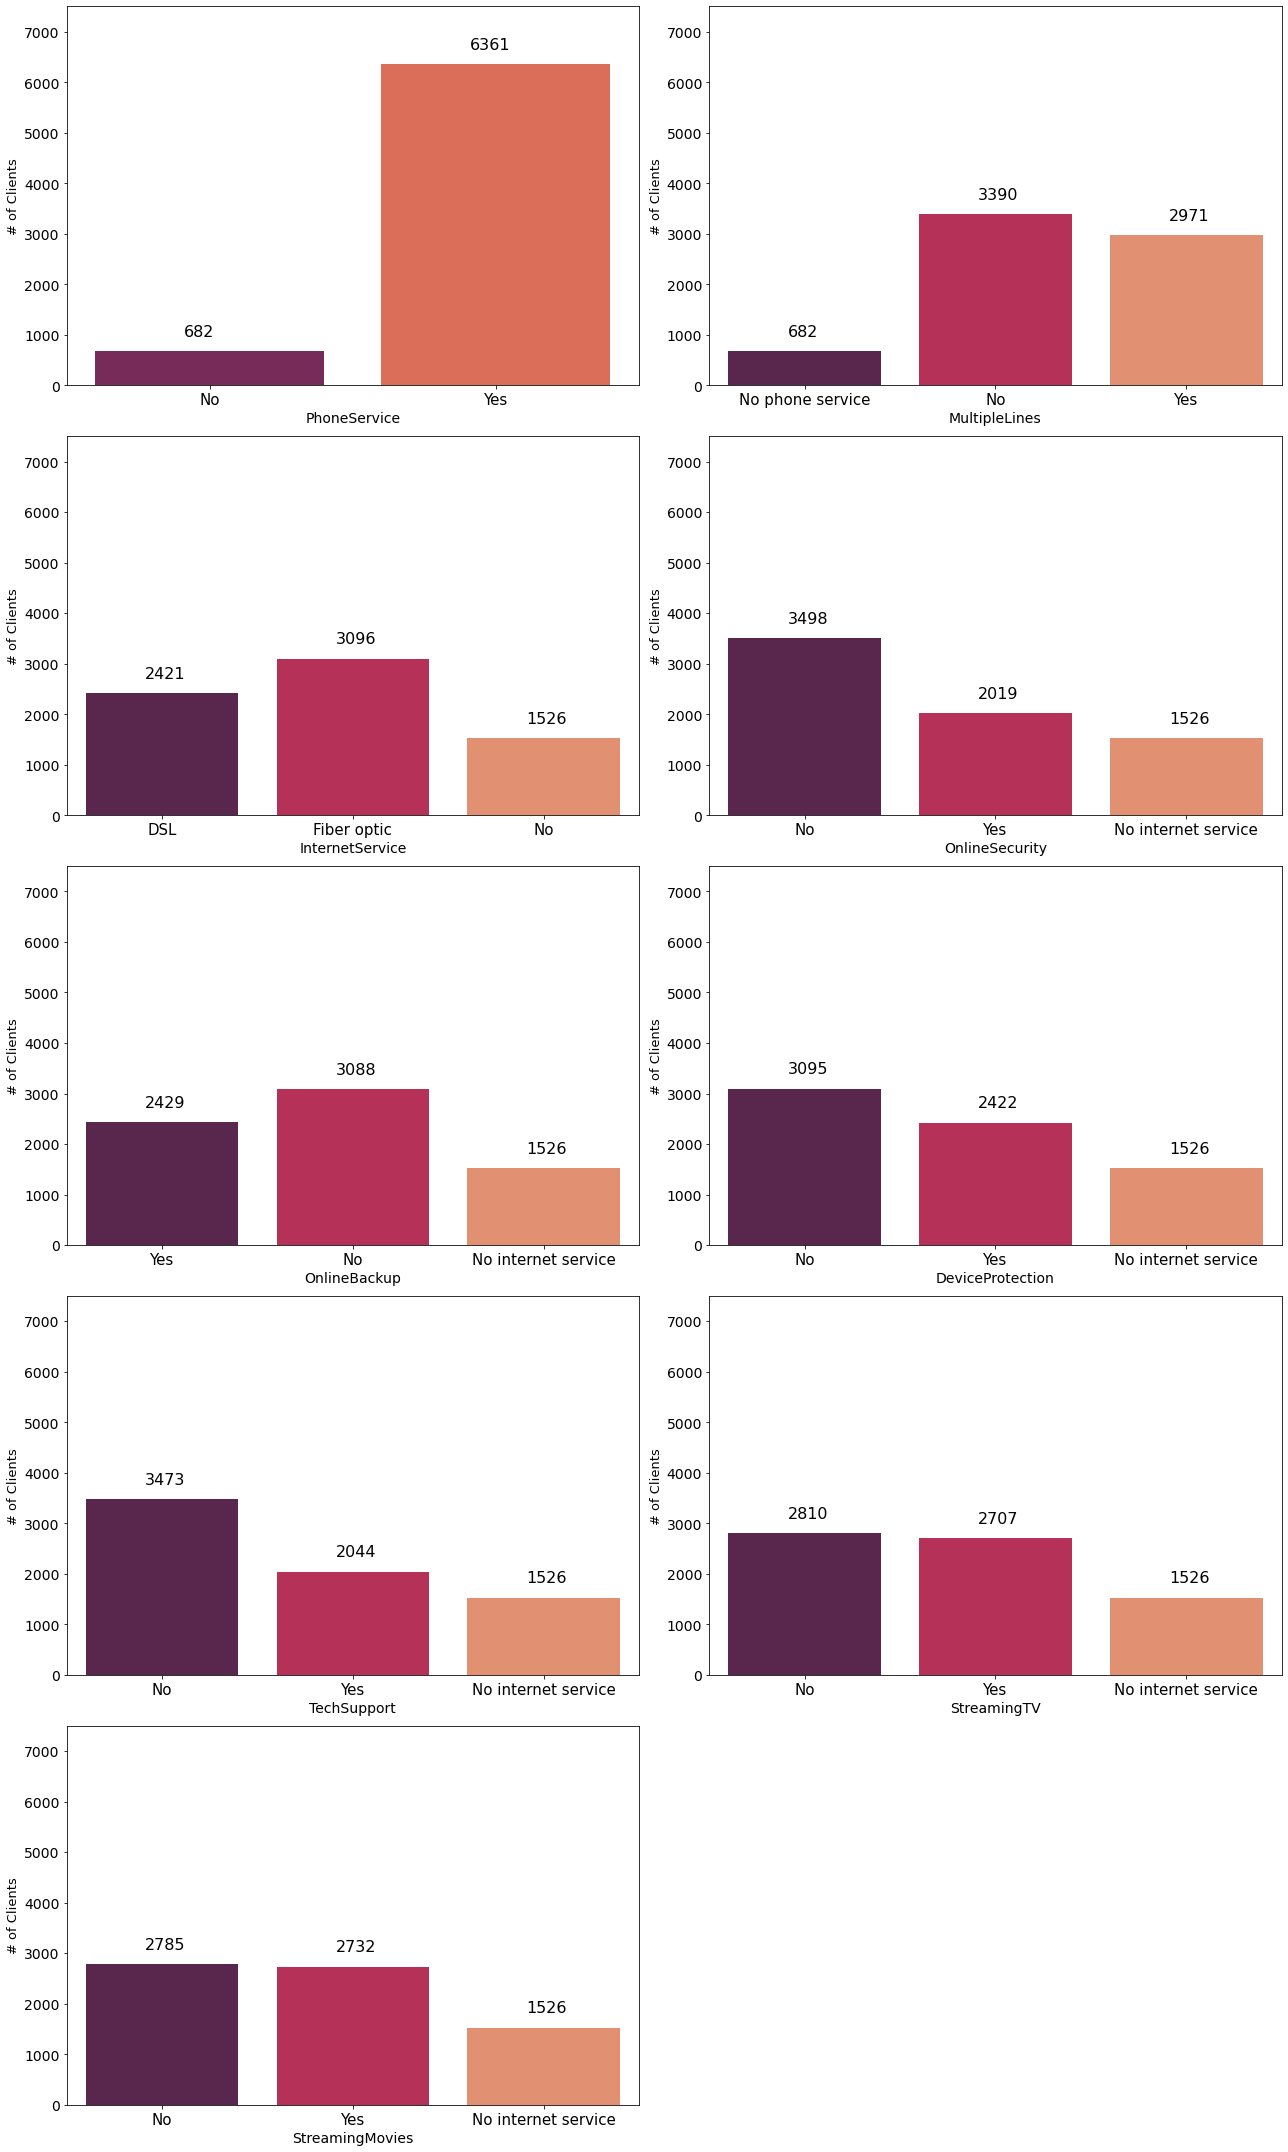

In [26]:
plt.figure(figsize=(18,30))

for i,col in enumerate(serv_features):    
    plt.subplot(5,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7500)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.31, p.get_height()+300), fontsize= 16)

plt.tight_layout()

plt.show()

一小部分客户没有互联网服务，更小的客户没有电话服务。

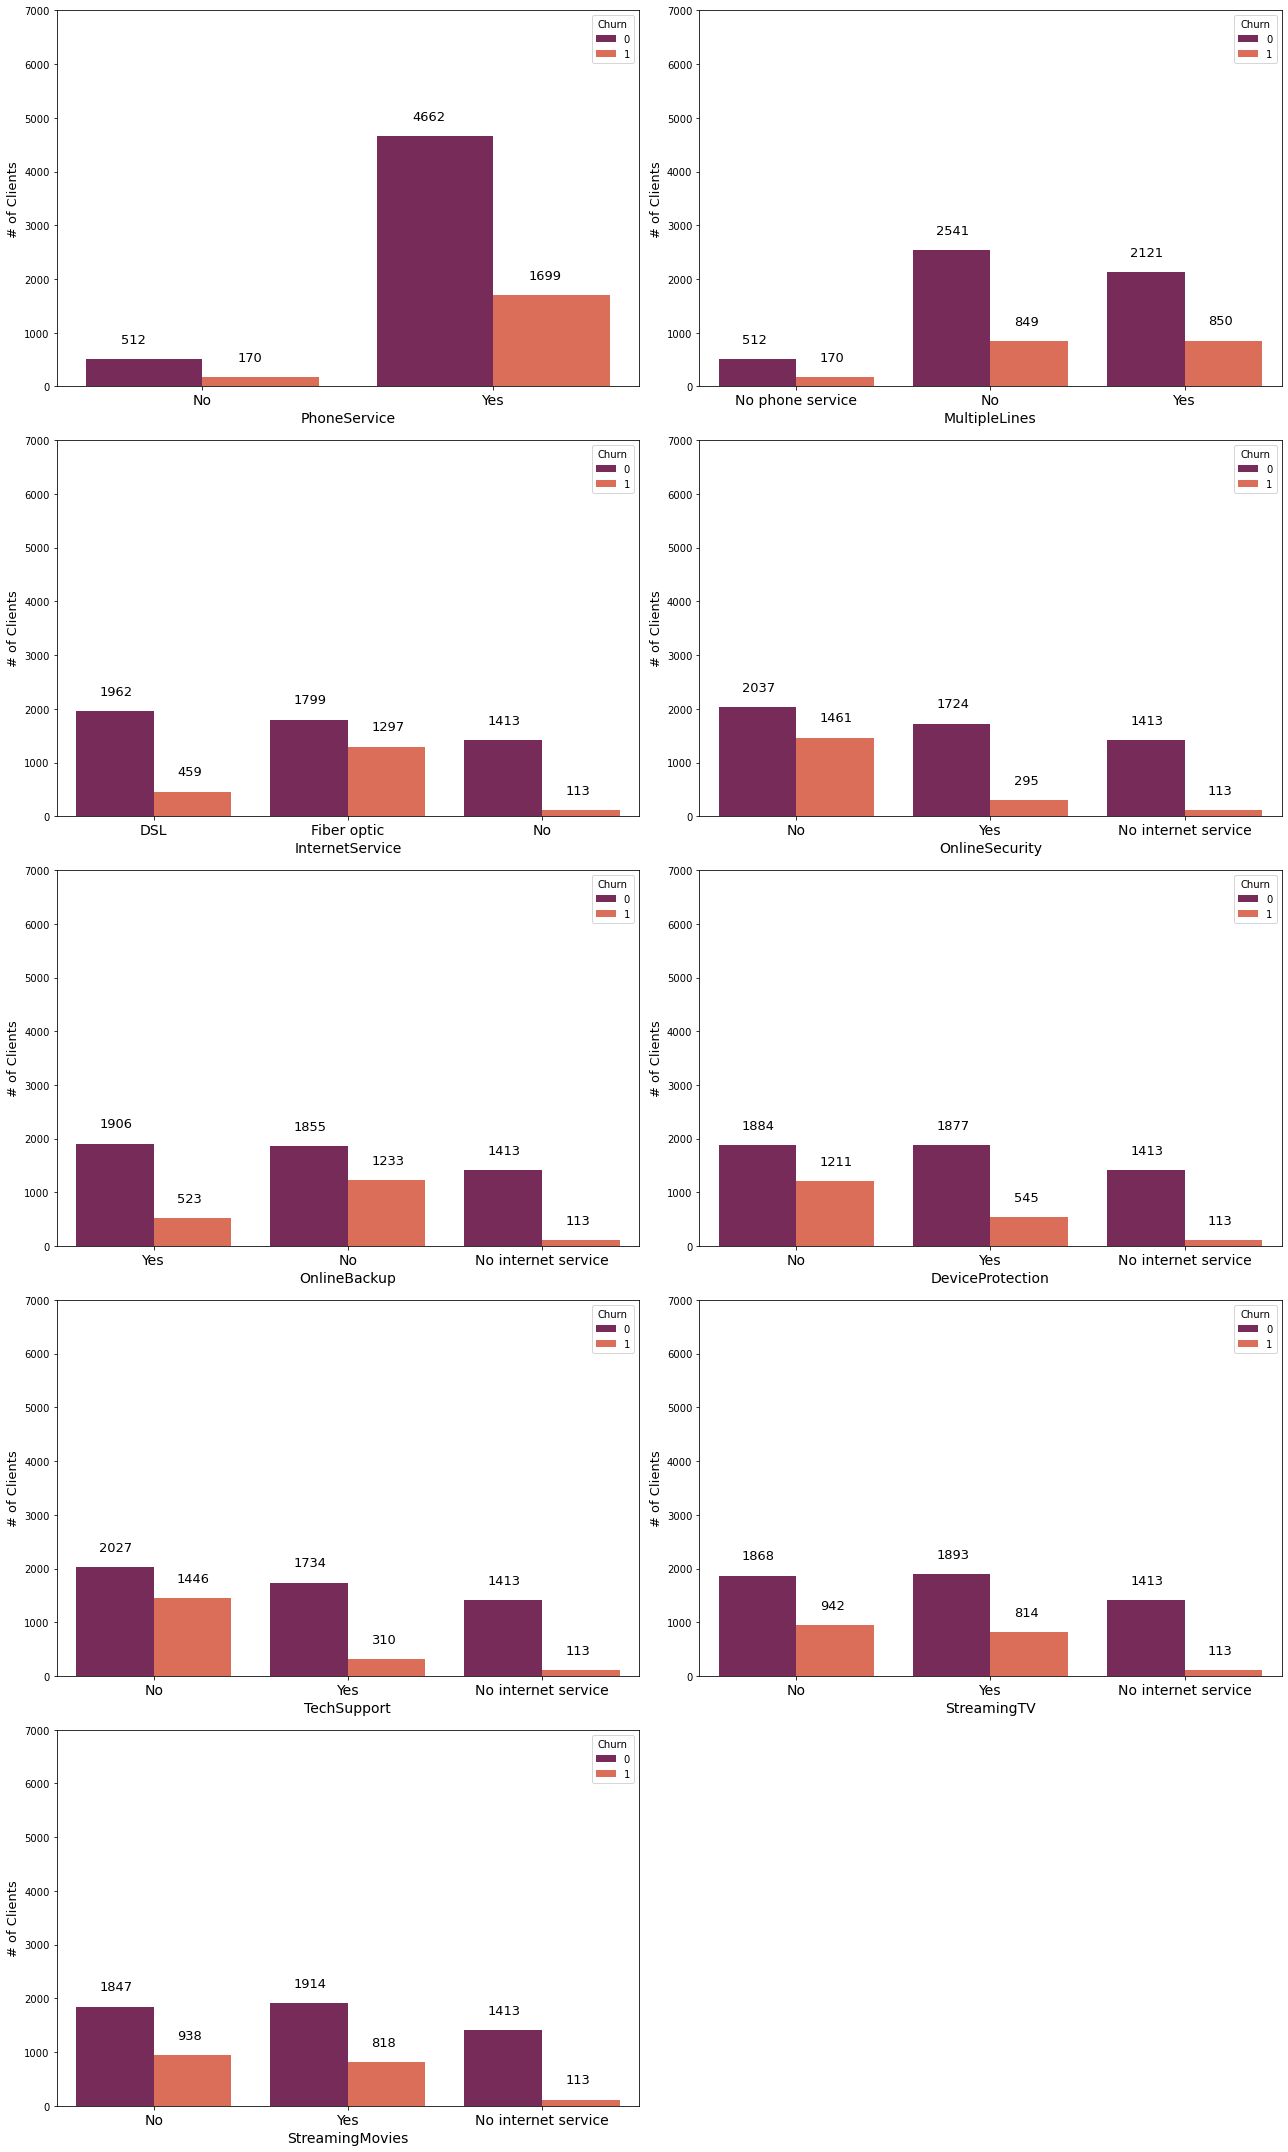

In [27]:
plt.figure(figsize=(18,30))

for i,col in enumerate(serv_features):    
    plt.subplot(5,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn", palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7000)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.12, p.get_height()+300), fontsize= 13)

plt.tight_layout()

plt.show()

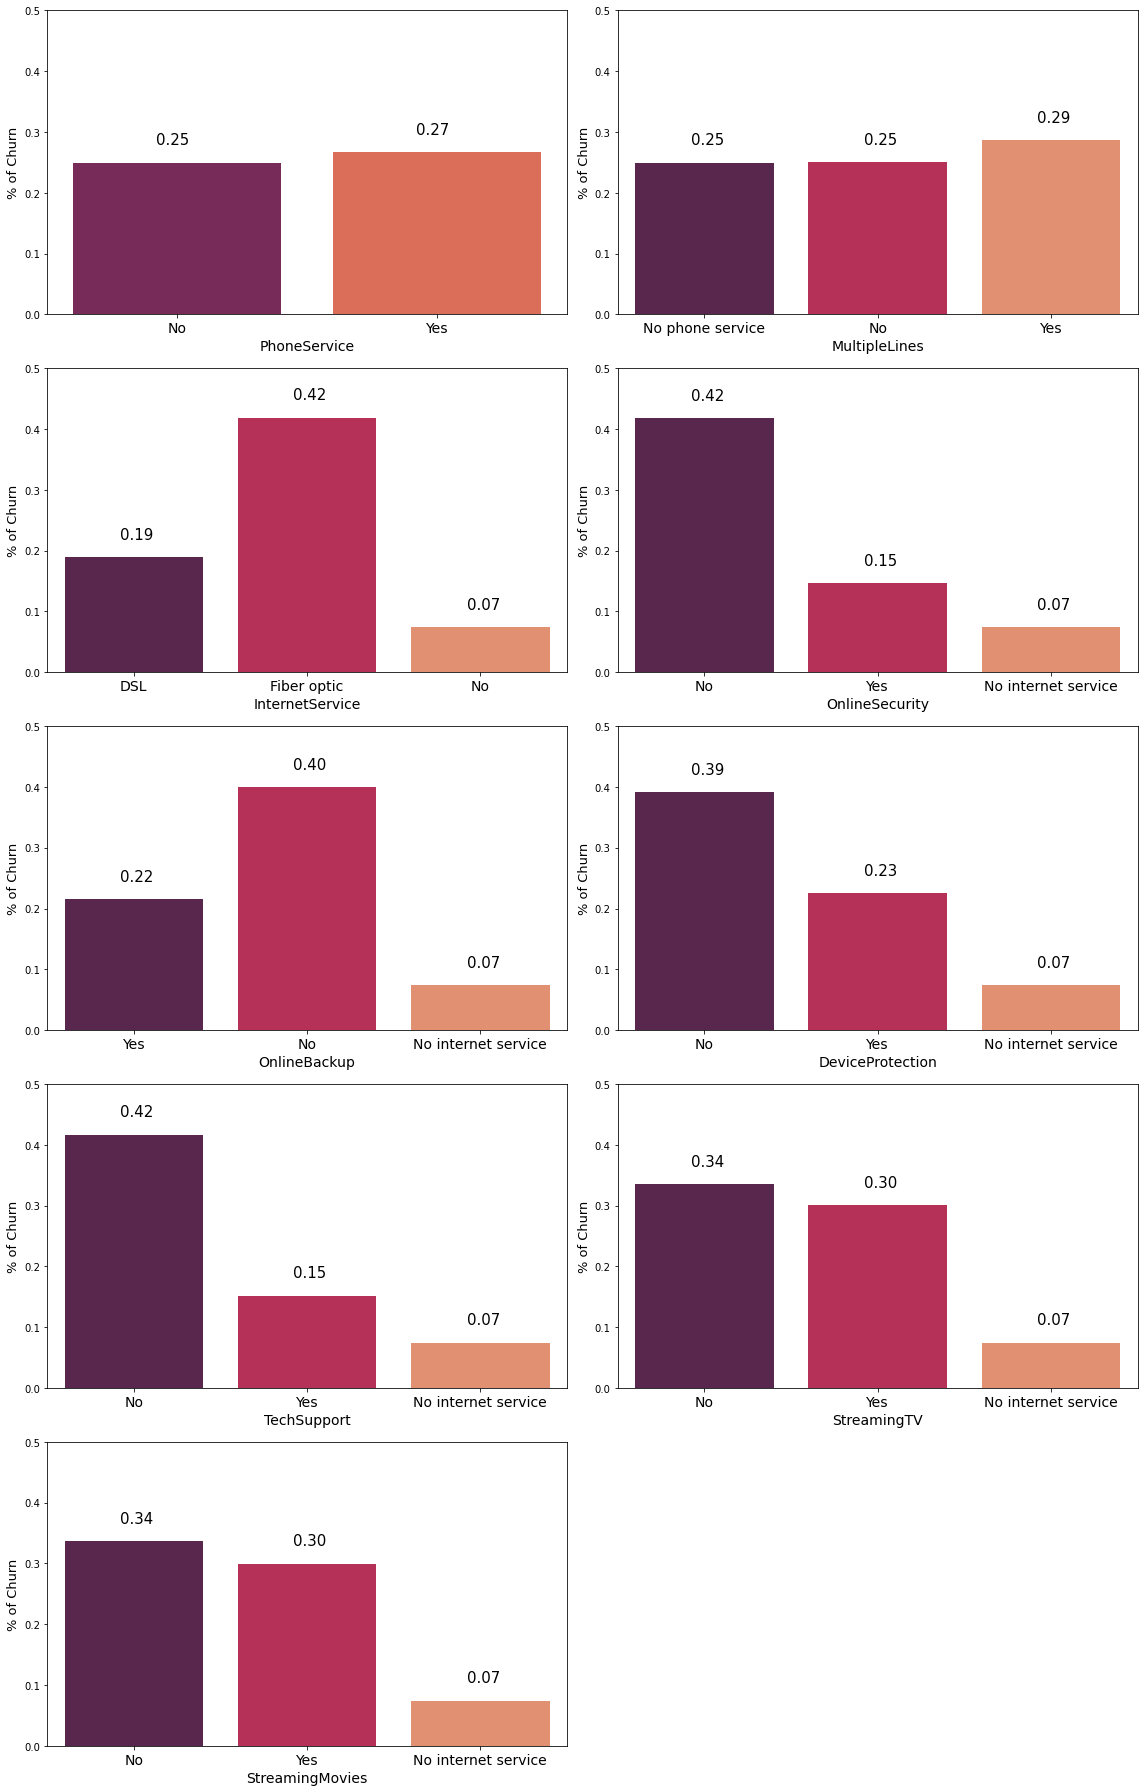

In [28]:
plt.figure(figsize=(16,25))

for i,col in enumerate(serv_features):    
    plt.subplot(5,2,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df, palette = 'rocket', ci = None)

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("% of Churn", fontsize= 13)
    plt.ylim(0,0.5)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.32, p.get_height()+0.03),fontsize=15)

plt.tight_layout()

plt.show()

奇怪的是，有电话服务和没有电话服务的客户之间的流失差异非常小，如果我们把那些有多条线路的客户排除在外，则可以忽略不计。
在这组功能中，在客户保留方面真正改变游戏规则的是与互联网服务相关的功能。

在“InternetServices”数据集中，每个类别的流失百分比都大不相同。
那些不订阅公司互联网的人（大概，他们只使用他们的电话服务），最有可能成为他们的客户。
使用 DSL 服务的客户流失的可能性也小于总体概率。

流失率最高，超过 40%，来自使用光纤互联网的客户。
光纤往往比 DSL 互联网更快，但它们的订阅通常也更贵。
我们没有关于每项服务的费用的信息，但至少我们可以找到每种类型的互联网每月费用的平均值，只是为了了解情况就是如此。

In [29]:
df.groupby(by=['InternetService'])['MonthlyCharges'].mean().sort_values()

InternetService
No             21.079194
DSL            58.102169
Fiber optic    91.500129
Name: MonthlyCharges, dtype: float64

正如预期的那样，每项服务的平均费用有很大不同，光纤是最贵的。
在没有任何额外信息的情况下，很难得出明确的结论，但他们的光纤服务的成本效益关系似乎远不足以留住客户。

如此高的流失率可能表明他们的服务质量在速度和/或可靠性方面低于标准。
分析客户服务呼叫中心服务收到的投诉以提取有关其互联网的有用和特定信息是必须的。
对大量客户进行调查，旨在了解他们如何看待服务质量，是发现问题并帮助确定行动方案的另一个步骤。

至于其他服务，拥有每一项服务的客户流失的可能性实际上低于那些没有的客户。 
“技术支持”和“在线安全”的差异较大，而流媒体服务的差异较小。

让我们计算技术支持和在线安全功能中每个类别的平均每月费用。

In [30]:
print(df.groupby(by=['TechSupport'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['OnlineSecurity'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['OnlineSecurity', 'TechSupport'])['MonthlyCharges'].mean().sort_values())

TechSupport
No internet service    21.079194
No                     74.586683
Yes                    80.680137
Name: MonthlyCharges, dtype: float64 

OnlineSecurity
No internet service    21.079194
No                     75.693067
Yes                    78.838732
Name: MonthlyCharges, dtype: float64 

OnlineSecurity       TechSupport        
No internet service  No internet service    21.079194
No                   No                     74.188367
Yes                  No                     75.692011
No                   Yes                    79.758148
Yes                  Yes                    81.472930
Name: MonthlyCharges, dtype: float64


这两项服务似乎对订阅费用影响不大。
如果公司可以量化为每位客户提供每项服务的成本并发现成本相对较小，他们可以减少这些额外服务的额外订阅费，或者简单地削减该费用并将这些服务作为互联网客户的标准提供试用期。
鉴于大多数客户不订阅这些服务，并且它们对客户保留有重大影响，从长远来看，这种策略可能会带来更高的利润。

让我们看看同时使用这两种服务的客户的流失率是否会显着降低。

In [31]:
print(df.groupby(by=['TechSupport'])['OnlineSecurity'].value_counts(), '\n')

TechSupport          OnlineSecurity     
No                   No                     2553
                     Yes                     920
No internet service  No internet service    1526
Yes                  Yes                    1099
                     No                      945
Name: OnlineSecurity, dtype: int64 



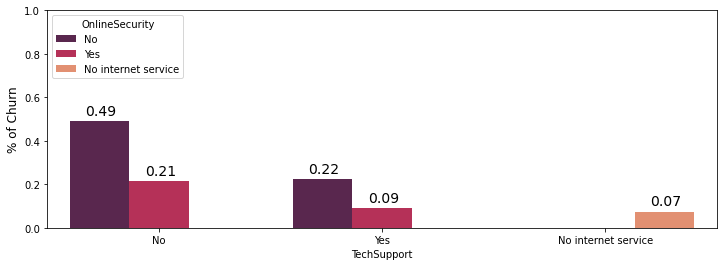

In [32]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "TechSupport", y = "Churn", hue = "OnlineSecurity", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,1.0)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.070, p.get_height()+0.03),fontsize=14)

plt.show()

流失率方面的差异非常显着。
虽然不使用这两种服务的客户流失率接近 50%，但同时使用这两种服务的客户流失率低于 10%，支持前一条观点。

## <a id="33">账户信息特征（分类）</a> 

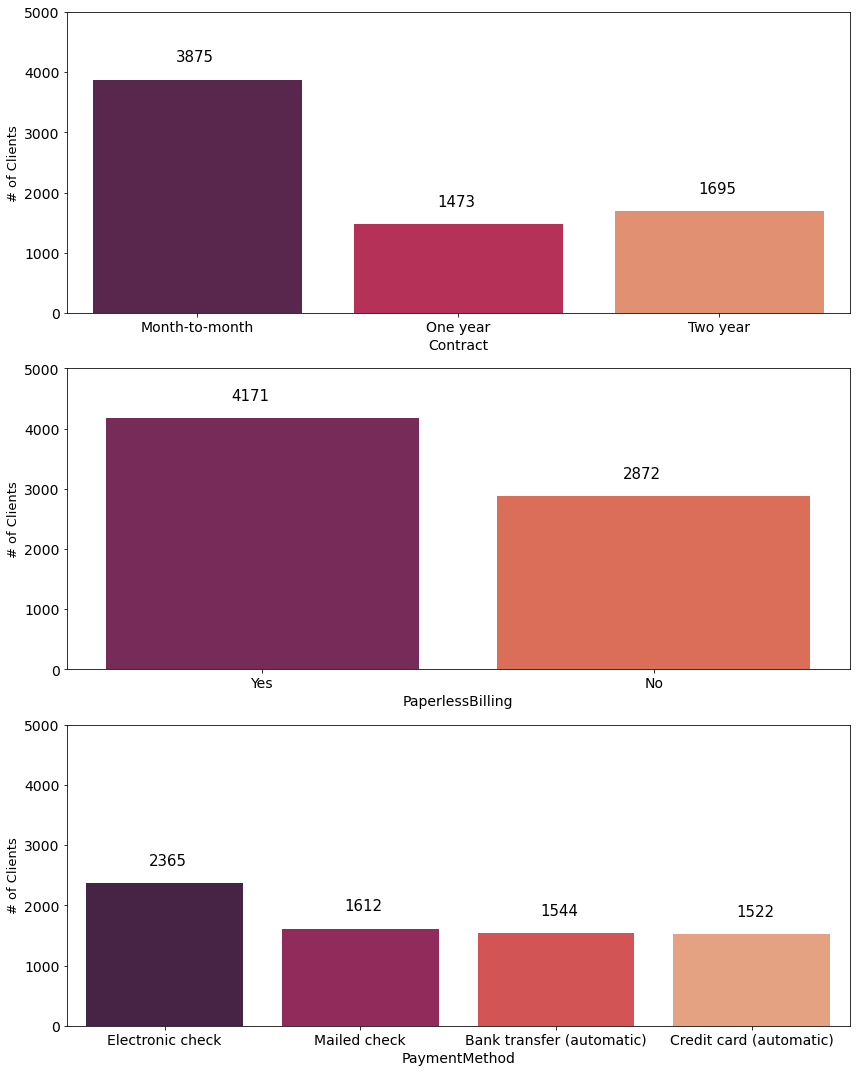

In [33]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.countplot(data = df, x = col, palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,5000)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+300), fontsize= 15)

plt.tight_layout()

plt.show()

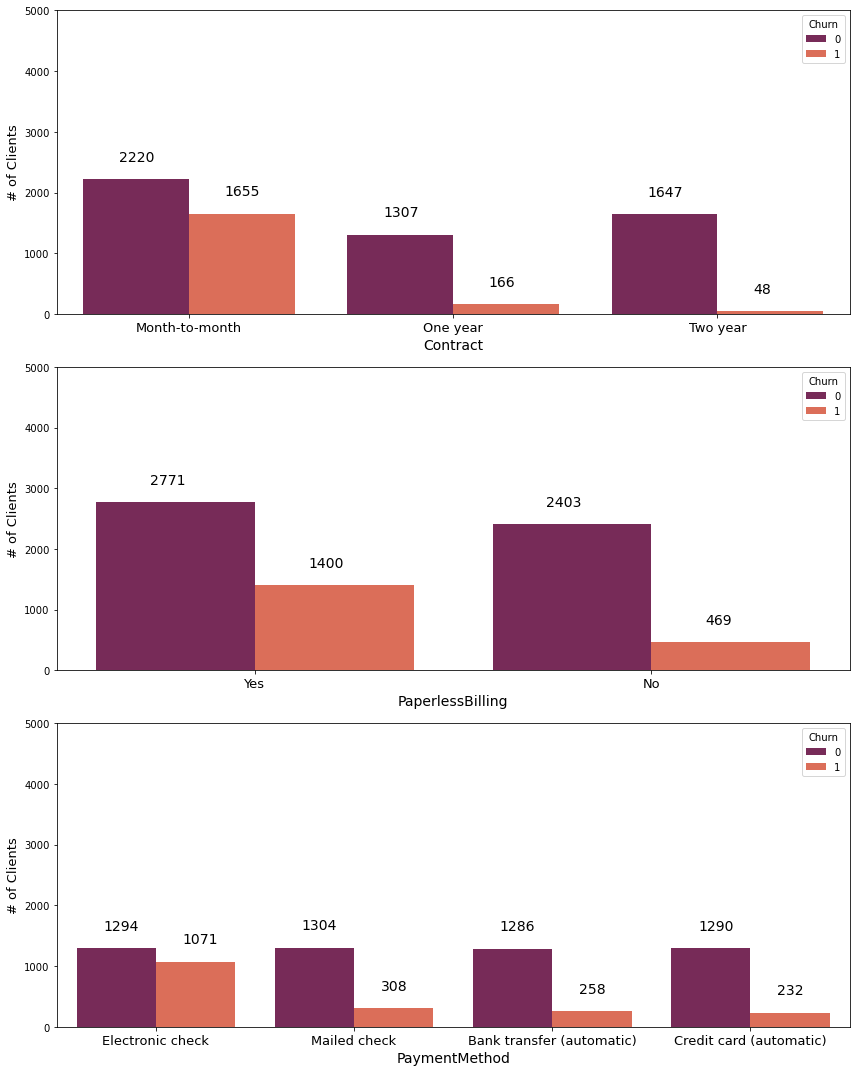

In [34]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn", palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,5000)
    plt.xticks(fontsize= 13)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.135, p.get_height()+300), fontsize= 14)

plt.tight_layout()

plt.show()

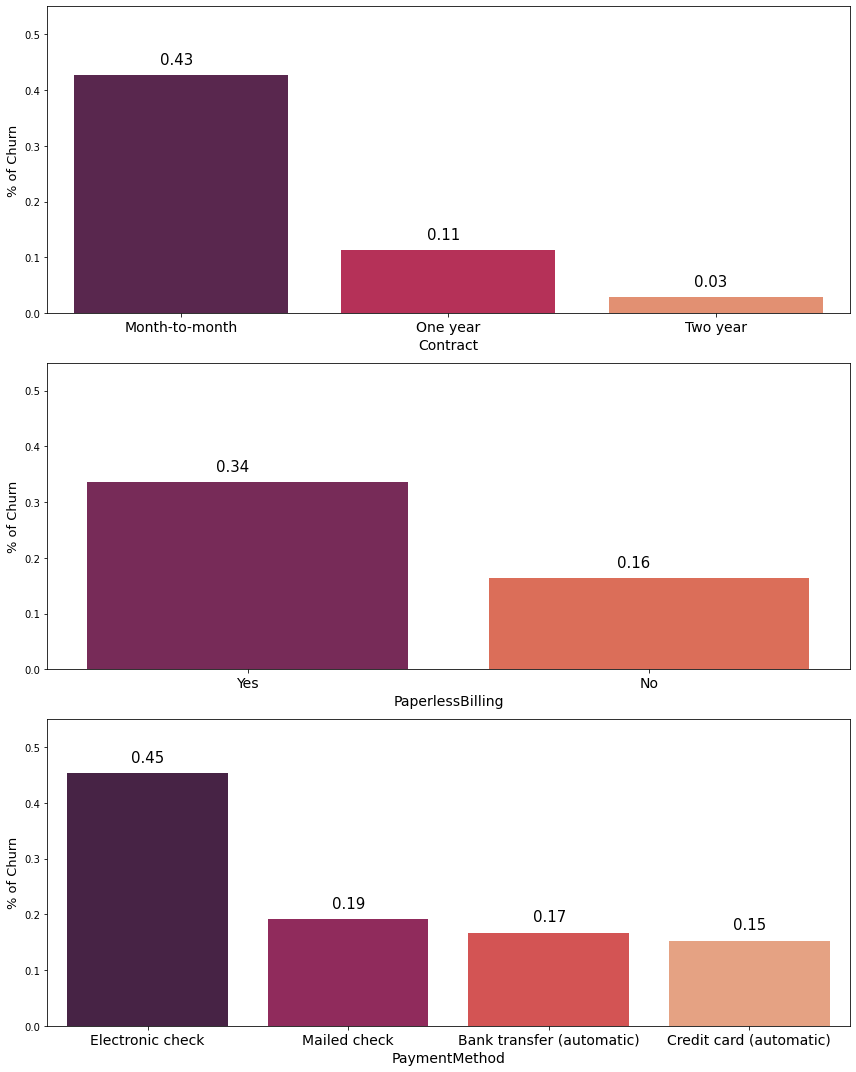

In [35]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df, palette = 'rocket', ci = None)

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("% of Churn", fontsize= 13)
    plt.ylim(0,0.55)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.32, p.get_height()+0.02),fontsize=15)

plt.tight_layout()

plt.show()

自然而然，就合约而言，流失率最高的来自“逐月”类型，这也是最主要的合约。
奇怪的是，选择电子支票作为付款方式并选择无纸化计费的客户流失的可能性很高。
例如，月度合同中的大多数客户也可能属于这些类别。
我们可以检查一下。

In [36]:
print(df.groupby(by=['Contract'])['PaperlessBilling'].value_counts(normalize = True),' \n')
print(df.groupby(by=['Contract'])['PaymentMethod'].value_counts(normalize = True))
df.head()

Contract        PaperlessBilling
Month-to-month  Yes                 0.667355
                No                  0.332645
One year        Yes                 0.543109
                No                  0.456891
Two year        No                  0.536873
                Yes                 0.463127
Name: PaperlessBilling, dtype: float64  

Contract        PaymentMethod            
Month-to-month  Electronic check             0.477419
                Mailed check                 0.230452
                Bank transfer (automatic)    0.152000
                Credit card (automatic)      0.140129
One year        Credit card (automatic)      0.270197
                Bank transfer (automatic)    0.265445
                Electronic check             0.235574
                Mailed check                 0.228785
Two year        Credit card (automatic)      0.342773
                Bank transfer (automatic)    0.332743
                Mailed check                 0.225369
                Ele

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


当我们按合同对数据集进行分组时，我们可以看到，对于“逐月”类型，未通过邮件收到账单并通过电子支票付款的客户百分比更高。
然而，这似乎不足以证明这些类别的流失率如此之高。
无论合同类型如何，我们很有可能会发现其中的流失率更高。
让我们来看看。

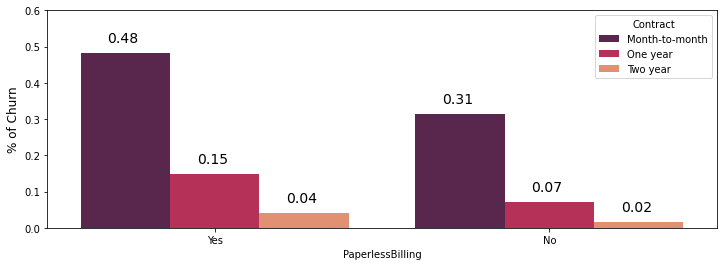

In [37]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "PaperlessBilling", y = "Churn", hue = "Contract", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.6)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.08, p.get_height()+0.03),fontsize=14)

plt.show()

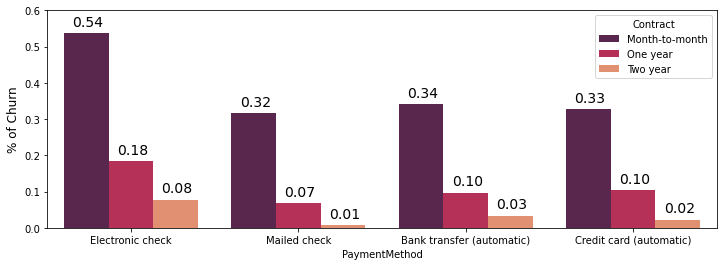

In [38]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "PaymentMethod", y = "Churn", hue = "Contract", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.6)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.05, p.get_height()+0.020),fontsize=14)

plt.show()

事实上，无论合同类型如何，这些类别的流失可能性都更高。

就我个人而言，在没有额外信息或领域知识的情况下，我很难看出流失率与某人收到账单并选择付款的方式之间存在因果关系。

这两个特征更有可能与其他几个特征相关联。

互联网服务是每个类别之间流失率显着差异的特征，可以在它们之间呈现一些相关性。

In [39]:
print(df.groupby(by=['InternetService'])['PaperlessBilling'].value_counts(normalize = True), '\n')
print(df.groupby(by=['InternetService'])['PaymentMethod'].value_counts(normalize = True))

InternetService  PaperlessBilling
DSL              Yes                 0.549360
                 No                  0.450640
Fiber optic      Yes                 0.773579
                 No                  0.226421
No               No                  0.707733
                 Yes                 0.292267
Name: PaperlessBilling, dtype: float64 

InternetService  PaymentMethod            
DSL              Electronic check             0.267658
                 Mailed check                 0.253201
                 Credit card (automatic)      0.245353
                 Bank transfer (automatic)    0.233788
Fiber optic      Electronic check             0.515181
                 Bank transfer (automatic)    0.208656
                 Credit card (automatic)      0.192829
                 Mailed check                 0.083333
No               Mailed check                 0.485583
                 Bank transfer (automatic)    0.217562
                 Credit card (automatic)      0.216907
 

在我们的分组操作中，突出之处在于： 
- 使用互联网服务的客户 =“否”：不到 30% 的客户收到无纸账单，只有 8% 的客户使用电子支票付款； 

- 使用互联网服务的客户 =“光纤”：77% 的客户收到无纸账单，51% 的客户使用电子支票付款。

我们可以回想一下，互联网服务功能中流失率最低的是那些不使用电信互联网的客户，而使用光纤互联网的客户流失率最高。

因此，我们可以说这些结果并不令人意外。

虽然我们不应该得出结论，付款方式或账单发送方式对客户保留有直接影响，但值得指出的是，这些特征可能对我们的预测模型有用。

## <a id="34">账户信息特征（数字）</a> 

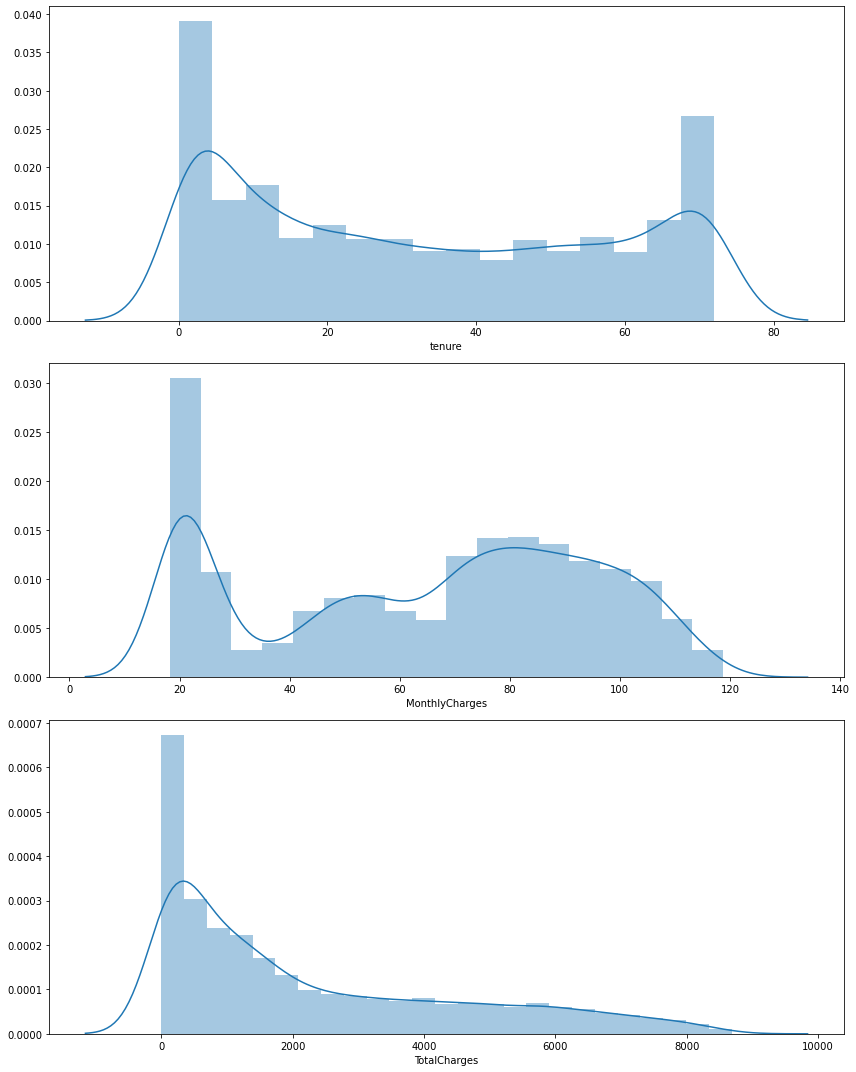

In [40]:
plt.figure(figsize=(12,15))

for i,col in enumerate(num_accinfo_features):    
    plt.subplot(3,1,i + 1)
    sns.distplot(df.loc[:,col])
    #plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation    
    plt.ylabel('')
    plt.tight_layout()

plt.show()

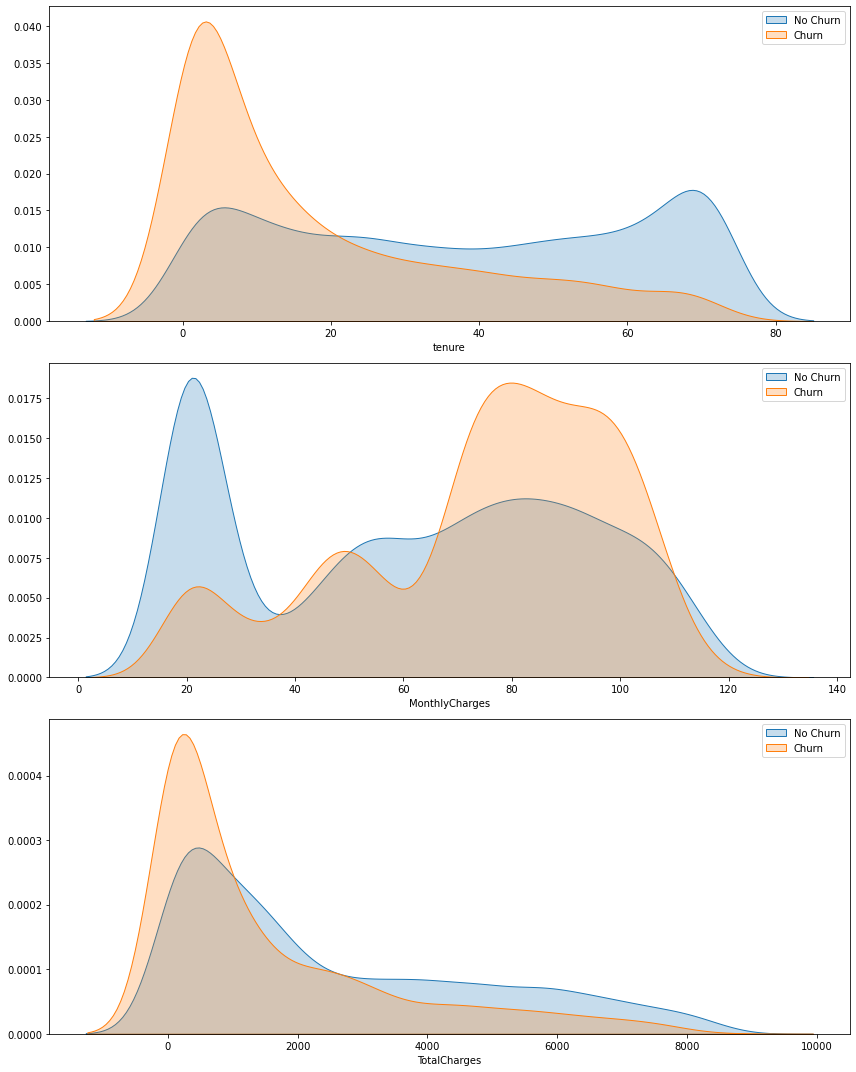

In [41]:
plt.figure(figsize=(12,15))

for i,col in enumerate(num_accinfo_features):    
    plt.subplot(3,1,i + 1)    
    sns.kdeplot(df.loc[(df['Churn'] == 0), col], label = 'No Churn', shade = True)
    sns.kdeplot(df.loc[(df['Churn'] == 1), col], label = 'Churn', shade = True)
    plt.legend()
    plt.ylabel('')
    plt.tight_layout()

plt.show()

对于每个特征，我们可以观察到： 任期：最初几个月流失的客户高度集中。

每月费用：流失客户高度集中，价值较高（大约 60 岁及以上） 总费用：分布有些相似，但“无流失”分布的价值较低。

让我们得到平均值来补充我们的分析。

In [42]:
print(df.groupby(by=['Churn'])['tenure'].mean().sort_values(), '\n')
print(df.groupby(by=['Churn'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['Churn'])['TotalCharges'].mean().sort_values())

Churn
1    17.979133
0    37.569965
Name: tenure, dtype: float64 

Churn
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64 

Churn
1    1531.796094
0    2549.911442
Name: TotalCharges, dtype: float64


正如预期的那样，流失客户的平均任期较短，平均每月费用高于留存客户的相同指标。

流失客户的平均总费用较低，这可能是由于他们的任期较短。 

“任期”功能中流失客户的密度图在前几个月显示出高度集中。

让我们将此功能划分为多个 bin 以获得每年服务的流失率

In [43]:
df['tenure_bin'] = pd.cut(df['tenure'],[-1,12,24,36,48,60,100])
df['tenure_bin'].value_counts(sort = False)

(-1, 12]     2186
(12, 24]     1024
(24, 36]      832
(36, 48]      762
(48, 60]      832
(60, 100]    1407
Name: tenure_bin, dtype: int64

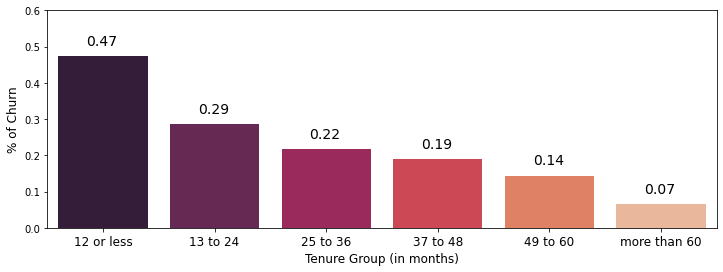

In [44]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "tenure_bin", y = "Churn", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.6)
plt.xticks([0,1,2,3,4,5], ['12 or less', '13 to 24', '25 to 36', '37 to 48', '49 to 60', 'more than 60'], fontsize = 12)
plt.xlabel("Tenure Group (in months)", fontsize= 12)



for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=14)

plt.show()

在成为客户一年或更短时间的人中，几乎 50% 最终离开了公司。

对于某些类型的业务，在第一年或第二年有较高的流失率并不罕见。

然而，第一年如此高的流失率表明所提供的服务质量未能满足新客户的期望。

# <a id="4">创建和评估模型</a>

现在，让我们继续讨论预测模型。 在本notebook中，我们将使用接收器特征算子曲线下面积（AUC-ROC 或 ROC-AUC）作为评估模型性能的主要指标。 ROC-AUC 衡量模型区分类别的能力。尽管如此，我们还将检查每个模型的准确性、分类报告和混淆矩阵。

首先，我们将复制数据集并将特征与目标分开。

In [45]:

X = df.copy().drop('Churn', axis = 1)
Y = df['Churn'].copy()

In [46]:
X

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_bin
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,"(-1, 12]"
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,"(24, 36]"
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,"(-1, 12]"
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,"(36, 48]"
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,"(-1, 12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,"(12, 24]"
7039,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,"(60, 100]"
7040,4801-JZAZL,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,"(-1, 12]"
7041,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,"(-1, 12]"


我们还将删除为 EDA 目的而创建的 customer_id 和特征“tenure_bin”，因为我们不打算使用它们

In [47]:
X = X.drop(['customerID', 'tenure_bin'], axis = 1)
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60


In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [49]:
gender_map = {'Female': 0, 'Male': 1}
yes_or_no_map = {'No': 0, 'Yes': 1} #seniorcitizen, partner, dependents, phoneservice, paperlessbilling
multiplelines_map = {'No phone service': -1, 'No': 0, 'Yes': 1}
internetservice_map = {'No': -1, 'DSL': 0, 'Fiber optic': 1}
add_netservices_map = {'No internet service': -1, 'No': 0, 'Yes': 1} #onlinesecurity, onlinebackup, deviceprotection,techsupport,streaming services
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
paymentmethod_map = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}


X['gender'] = X['gender'].map(gender_map).astype('int')
X['Partner'] = X['Partner'].map(yes_or_no_map).astype('int')
X['SeniorCitizen'] = X['SeniorCitizen'].map(yes_or_no_map).astype('int')
X['Dependents'] = X['Dependents'].map(yes_or_no_map).astype('int')
X['PhoneService'] = X['PhoneService'].map(yes_or_no_map).astype('int')
X['MultipleLines'] = X['MultipleLines'].map(multiplelines_map).astype('int')
X['InternetService'] = X['InternetService'].map(internetservice_map).astype('int')
X['OnlineSecurity'] = X['OnlineSecurity'].map(add_netservices_map).astype('int')
X['OnlineBackup'] = X['OnlineBackup'].map(add_netservices_map).astype('int')
X['DeviceProtection'] = X['DeviceProtection'].map(add_netservices_map).astype('int')
X['TechSupport'] = X['TechSupport'].map(add_netservices_map).astype('int')
X['StreamingTV'] = X['StreamingTV'].map(add_netservices_map).astype('int')
X['StreamingMovies'] = X['StreamingMovies'].map(add_netservices_map).astype('int')
X['Contract'] = X['Contract'].map(contract_map).astype('int')
X['PaperlessBilling'] = X['PaperlessBilling'].map(yes_or_no_map).astype('int')
X['PaymentMethod'] = X['PaymentMethod'].map(paymentmethod_map).astype('int')

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int32  
 1   SeniorCitizen     7043 non-null   int32  
 2   Partner           7043 non-null   int32  
 3   Dependents        7043 non-null   int32  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int32  
 6   MultipleLines     7043 non-null   int32  
 7   InternetService   7043 non-null   int32  
 8   OnlineSecurity    7043 non-null   int32  
 9   OnlineBackup      7043 non-null   int32  
 10  DeviceProtection  7043 non-null   int32  
 11  TechSupport       7043 non-null   int32  
 12  StreamingTV       7043 non-null   int32  
 13  StreamingMovies   7043 non-null   int32  
 14  Contract          7043 non-null   int32  
 15  PaperlessBilling  7043 non-null   int32  
 16  PaymentMethod     7043 non-null   int32  


现在我们将数据分成训练集和测试集。

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)
X[0:1]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,-1,0,0,1,0,0,0,0,0,1,0,29.85,29.85


## <a id="41">逻辑回归</a> 

我们要使用的第一个模型是逻辑回归，它需要两件事才能获得更好的性能：
- 缩放数字特征；
- 对分类特征进行编码。

我们可以使用 Column Transformer 将每个转换分配给其正确的特征，并将其放入管道中作为预处理步骤。

In [52]:
num_features = num_accinfo_features

cat_3p_features = []
for col in X.columns:
    if (X[col].nunique() > 2) & (X[col].nunique() < 5):  #less than 5 to exclude the numerical features
        cat_3p_features.append(col)
print('Numerical features: ', num_features, '\n')        
print('Nominal with 3 or more categories: ', cat_3p_features)

Numerical features:  ['tenure', 'MonthlyCharges', 'TotalCharges'] 

Nominal with 3 or more categories:  ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [53]:
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_3p_features)      
    ], remainder='passthrough')

In [54]:
lr_pipe = Pipeline([('Transformers', preprocessor)
                        ,('LR',  LogisticRegression(random_state = 42, max_iter = 1000))])

即使不打算进行大量的超参数调整，我们也可以通过测试关键参数的一些值并根据交叉验证分数选择其中一个值，为每个模型提供更好的性能机会。

In [55]:
def cv_function (model, param, list):
    
    rp_st_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state = 42)
    search_model = model
    print ('Hyperparameter: ', param)
    
    for i in list:
        param_dict = {param : i}
        search_model.set_params(**param_dict)    
        cv_score = cross_val_score(search_model, X_train, Y_train, cv=rp_st_kfold, scoring='roc_auc')
        print("Parameter: {0:0.2f} - AUC(SD): {1:0.4f} ({2:0.4f})". format(i, cv_score.mean(), cv_score.std()))
        
params_lr_list = [0.01,0.1,0.2,0.3,0.5,0.7,1,2,3,5]
param_lr = 'LR__C'
cv_function(lr_pipe, param_lr, params_lr_list)

Hyperparameter:  LR__C
Parameter: 0.01 - AUC(SD): 0.8435 (0.0142)
Parameter: 0.10 - AUC(SD): 0.8456 (0.0144)
Parameter: 0.20 - AUC(SD): 0.8459 (0.0144)
Parameter: 0.30 - AUC(SD): 0.8460 (0.0144)
Parameter: 0.50 - AUC(SD): 0.8461 (0.0144)
Parameter: 0.70 - AUC(SD): 0.8462 (0.0144)
Parameter: 1.00 - AUC(SD): 0.8463 (0.0144)
Parameter: 2.00 - AUC(SD): 0.8463 (0.0144)
Parameter: 3.00 - AUC(SD): 0.8464 (0.0143)
Parameter: 5.00 - AUC(SD): 0.8464 (0.0144)


过了一段时间，几乎没有改善。

选择：C = 3.0

In [56]:
lr_param = {'LR__C': 3.0}
lr_pipe.set_params(**lr_param) 
lr_pipe

Pipeline(steps=[('Transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                         

现在，让我们拟合这个模型并进行预测。

In [91]:
lr_pipe.fit(X_train, Y_train)
pred_lr = lr_pipe.predict(X[1:2])
a = X[1:2]
a = a.drop()
a
# print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_lr))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,1,56.95,1889.5


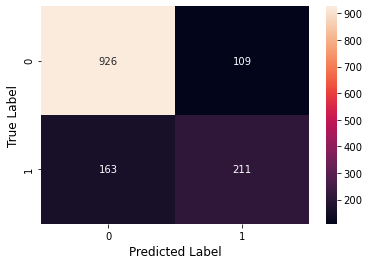

In [237]:
lr_confusion_matrix = metrics.confusion_matrix(Y_test, pred_lr)
sns.heatmap(lr_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [238]:
print(metrics.classification_report(Y_test, pred_lr, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



ROC_AUC:  0.8417473972461184


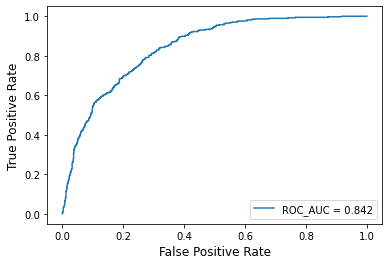

In [239]:
lr_pred_proba = lr_pipe.predict_proba(X_test)[:,1]

lr_roc_auc = metrics.roc_auc_score(Y_test, lr_pred_proba)
print('ROC_AUC: ', lr_roc_auc)

lr_fpr, lr_tpr, thresholds = metrics.roc_curve(Y_test, lr_pred_proba)

plt.plot(lr_fpr,lr_tpr, label = 'ROC_AUC = %0.3f' % lr_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

## <a id="42">随机森林算法</a> 

对于每个模型，除了使用管道进行预处理之外，我们将遵循我们使用 Logistic 回归所做的相同步骤。

In [240]:
rf_model = RandomForestClassifier(random_state = 42)

params_rf_list = [100,150,200,250,300,400,500]
param_rf = 'n_estimators'
cv_function(rf_model, param_rf, params_rf_list)

Hyperparameter:  n_estimators
Parameter: 100.00 - AUC(SD): 0.8262 (0.0155)
Parameter: 150.00 - AUC(SD): 0.8276 (0.0160)
Parameter: 200.00 - AUC(SD): 0.8284 (0.0161)
Parameter: 250.00 - AUC(SD): 0.8288 (0.0161)
Parameter: 300.00 - AUC(SD): 0.8293 (0.0161)
Parameter: 400.00 - AUC(SD): 0.8295 (0.0162)
Parameter: 500.00 - AUC(SD): 0.8297 (0.0162)


In [241]:
rf_param = {'n_estimators': 500}
rf_model.set_params(**rf_param) 
rf_model

RandomForestClassifier(n_estimators=500, random_state=42)

In [242]:
rf_model.fit(X_train, Y_train)
pred_rf = rf_model.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf))

Test Accuracy:  0.7877927608232789


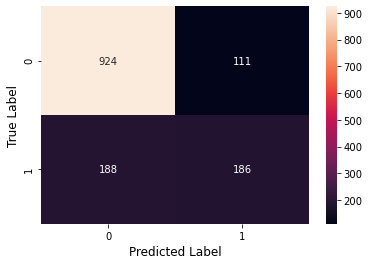

In [243]:
rf_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [244]:
print(metrics.classification_report(Y_test, pred_rf, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



ROC_AUC:  0.8251013976077916


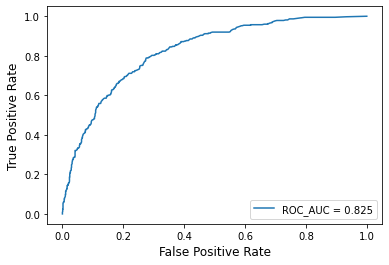

In [245]:
rf_pred_proba = rf_model.predict_proba(X_test)[:,1]

rf_roc_auc = metrics.roc_auc_score(Y_test, rf_pred_proba)
print('ROC_AUC: ', rf_roc_auc)

rf_fpr, rf_tpr, thresholds = metrics.roc_curve(Y_test, rf_pred_proba)

plt.plot(rf_fpr,rf_tpr, label = 'ROC_AUC = %0.3f' % rf_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

我们发现随机森林的结果非常令人失望。
尽管不需要特征缩放和一种热编码，但我们可以将它们仅用于测试目的。

## <a id="43">带预处理的随机森林</a> 

In [246]:
rf_pipe = Pipeline([('Transformers', preprocessor)
                        ,('RF',  RandomForestClassifier(n_estimators = 500, random_state = 42))])

rf_pipe.fit(X_train, Y_train)
pred_rf_pipe = rf_pipe.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf_pipe))

Test Accuracy:  0.7799858055358411


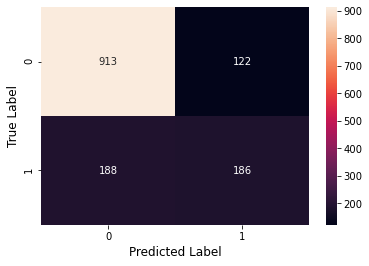

In [247]:
rf_pipe_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf_pipe)
sns.heatmap(rf_pipe_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [248]:
print(metrics.classification_report(Y_test, pred_rf_pipe, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.50      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



ROC_AUC:  0.823388617634142


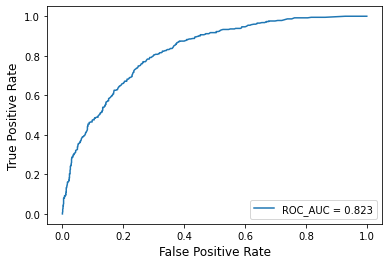

In [249]:
rf_pipe_pred_proba = rf_pipe.predict_proba(X_test)[:,1]

rf_pipe_roc_auc = metrics.roc_auc_score(Y_test, rf_pipe_pred_proba)
print('ROC_AUC: ', rf_pipe_roc_auc)

rf_pipe_fpr, rf_pipe_tpr, thresholds = metrics.roc_curve(Y_test, rf_pipe_pred_proba)

plt.plot(rf_pipe_fpr,rf_pipe_tpr, label = 'ROC_AUC = %0.3f' % rf_pipe_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()